# Population Modeling

In [1]:
import numpy as np;
import matplotlib.pyplot as plt;
import pandas as pd;
from matplotlib.pyplot import figure
import keras;
import tensorflow as tf;
from keras.preprocessing.sequence import TimeseriesGenerator;
from keras.models import Sequential
from keras.layers import LSTM, Dense
import plotly.graph_objects as go
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import Callback

In [2]:
df = pd.read_csv(r'C:\Users\emili\Downloads\population.csv')#, index_col = 'Date')
print(df.shape)
df.head()

(58099, 4)


,Entity,Code,Year,Population (historical estimates)
0,Afghanistan,AFG,-10000,14737
1,Afghanistan,AFG,-9000,20405
2,Afghanistan,AFG,-8000,28253
3,Afghanistan,AFG,-7000,39120
4,Afghanistan,AFG,-6000,54166


In [3]:
#df['Entity'].unique()

In [4]:
df_worldpop = df[df['Entity'] == 'World']
df_worldpop

,Entity,Code,Year,Population (historical estimates)
56940,World,OWID_WRL,-10000,4432266
56941,World,OWID_WRL,-9000,5616996
56942,World,OWID_WRL,-8000,7242892
56943,World,OWID_WRL,-7000,9577918
56944,World,OWID_WRL,-6000,13201832
...,...,...,...,...
57194,World,OWID_WRL,2017,7599822336
57195,World,OWID_WRL,2018,7683789824
57196,World,OWID_WRL,2019,7764951040
57197,World,OWID_WRL,2020,7840952832


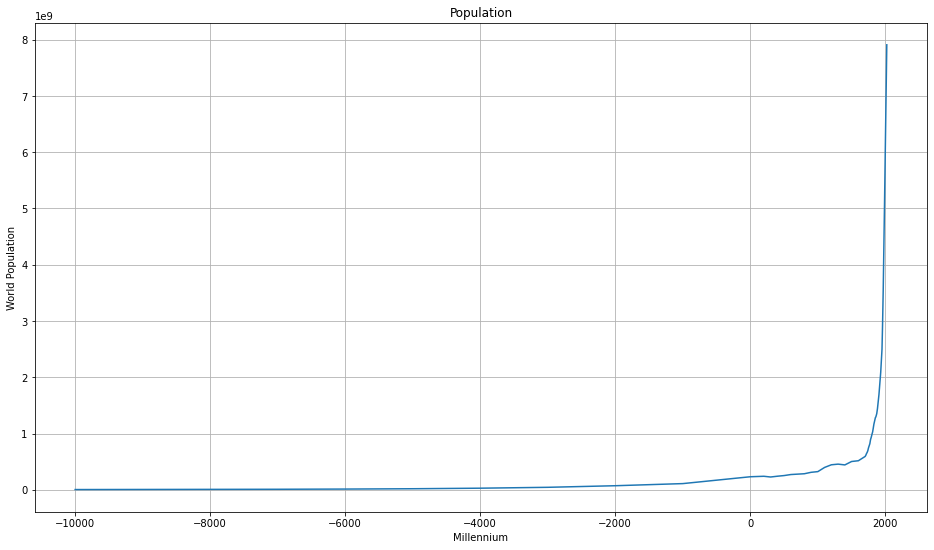

In [5]:
plt.fig = figure(figsize = (16,9))
plt.plot(df_worldpop['Year'],df_worldpop['Population (historical estimates)']);
plt.title('Population'); plt.ylabel('World Population'); plt.xlabel('Millennium')
plt.grid()

C:\Users\emili\AppData\Local\Temp\ipykernel_14844\861645106.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_worldpop['Population logged'] = df_worldpop['Population (historical estimates)'].apply(lambda x: np.log(x))


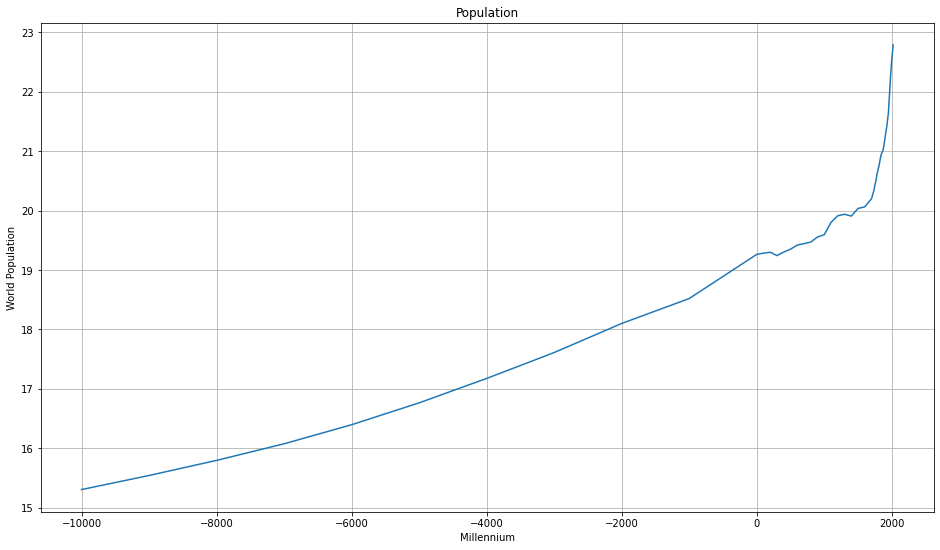

In [6]:
df_worldpop['Population logged'] = df_worldpop['Population (historical estimates)'].apply(lambda x: np.log(x))

plt.fig = figure(figsize = (16,9))
plt.plot(df_worldpop['Year'],df_worldpop['Population logged']);
plt.title('Population'); plt.ylabel('World Population'); plt.xlabel('Millennium')
plt.grid()

In [7]:
data = df_worldpop[['Year', 'Population logged']].values

# Define the input sequence length
sequence_length = 12

# Prepare the input sequences and target values
X = []
y = []
for i in range(sequence_length, len(data)):
    X.append(data[i - sequence_length:i])
    y.append(data[i])
X = np.array(X)
y = np.array(y)

# Define the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(sequence_length, 2)))
model.add(Dense(2))  # Output shape is (2,) for 'Year' and 'Population Logged'
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X, y, epochs=10, batch_size=1, verbose=1)

# Generate future sequences for prediction
future_sequences = []
last_sequence = X[-1]
for _ in range(5):  # Predict for the next 5 years
    next_year = last_sequence[-1, 0] + 1  # Increment the year by 1
    predicted_value = model.predict(np.reshape(last_sequence, (1, sequence_length, 2)))
    next_population = predicted_value[0, 1]  # Get the predicted population value
    future_sequences.append([next_year, next_population])
    last_sequence = np.vstack([last_sequence[1:], [next_year, next_population]])

# Convert the future sequences to a dataframe
future_df = pd.DataFrame(future_sequences, columns=['Year', 'Population Logged'])

# Print the future population predictions
print(future_df)

Epoch 1/10
247/247 [==============================] - 4s 5ms/step - loss: 1729090.5000
Epoch 2/10
247/247 [==============================] - 1s 5ms/step - loss: 1718329.1250
Epoch 3/10
247/247 [==============================] - 1s 5ms/step - loss: 1703167.3750
Epoch 4/10
247/247 [==============================] - 1s 5ms/step - loss: 1685207.0000
Epoch 5/10
247/247 [==============================] - 1s 5ms/step - loss: 1664874.6250
Epoch 6/10
247/247 [==============================] - 1s 5ms/step - loss: 1641904.6250
Epoch 7/10
247/247 [==============================] - 1s 5ms/step - loss: 1618370.5000
Epoch 8/10
247/247 [==============================] - 1s 5ms/step - loss: 1593550.0000
Epoch 9/10
247/247 [==============================] - 1s 5ms/step - loss: 1569965.6250
Epoch 10/10
1/1 [==============================] - 0s 32ms/step
     Year  Population Logged
0  2021.0          21.357555
1  2022.0          21.357555
2  2023.0          21.357555
3  2024.0          21.357555
4  2025.

In [8]:
trace1 = go.Scatter(
        x = df_worldpop['Year'],
        y = df_worldpop['Population logged'],
        mode='lines+markers',
        name = 'Training Data'
    )
trace2 = go.Scatter(
        x = future_df['Year'],
        y = future_df['Population Logged'],
        mode='lines+markers',
        name = '5 year Forecast'
    )
layout = go.Layout(
        title = ("World Population Forecast"),
        font = dict(size = 20),
        xaxis = {'title' : "Year"},
        yaxis = {'title' : "Population"}
    )
fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()

In [9]:
years_to_drop = [-10000, -9000, -8000, -7000, -6000, -5000, -4000, -3000, -2000, -1000, 0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1710, 1720, 1730, 1740, 1750, 1760, 1770, 1790]  # List of years to drop

df_worldpop.drop(df_worldpop[df_worldpop['Year'].isin(years_to_drop)].index, inplace=True)

df_worldpop

C:\Users\emili\AppData\Local\Temp\ipykernel_14844\3691110822.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Entity,Code,Year,Population (historical estimates),Population logged
56975,World,OWID_WRL,1780,891048681,20.607910
56977,World,OWID_WRL,1800,985340629,20.708498
56978,World,OWID_WRL,1801,987628322,20.710817
56979,World,OWID_WRL,1802,991098738,20.714325
56980,World,OWID_WRL,1803,994610260,20.717862
...,...,...,...,...,...
57194,World,OWID_WRL,2017,7599822336,22.751391
57195,World,OWID_WRL,2018,7683789824,22.762379
57196,World,OWID_WRL,2019,7764951040,22.772886
57197,World,OWID_WRL,2020,7840952832,22.782626


In [14]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, LeakyReLU
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import pandas as pd
import numpy as np

def generate_forecast(df, num_predictions):
    close_data = df['Population logged'].values
    close_data = close_data.reshape((-1, 1))

    split_percent = 0.80
    split = int(split_percent * len(close_data))

    close_train = close_data[:split]
    close_test = close_data[split:]

    look_back = 5

    train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=200)
    test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=200)

    model = tf.keras.Sequential()
    model.add(LSTM(30, activation=LeakyReLU(), input_shape=(look_back, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    num_epochs = 100
    model.fit(train_generator, epochs=num_epochs, verbose=1)
    prediction = model.predict(test_generator)

    close_train = close_train.reshape((-1))
    close_test = close_test.reshape((-1))
    prediction = prediction.reshape((-1))

    close_data = close_data.reshape((-1))

    def predict(num_prediction, model):
        prediction_list = close_data[-look_back:]

        for _ in range(num_prediction):
            x = np.array(prediction_list[-look_back:]).reshape((1, look_back, 1))
            out = model.predict(x)[0][0]
            prediction_list = np.append(prediction_list, out)
        prediction_list = prediction_list[look_back-1:]

        return prediction_list

    def predict_dates(num_prediction):
        last_date = df['Year'].values[-1]
        prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
        prediction_dates = [date.strftime('%Y-%m-%d') for date in prediction_dates]  # Convert dates to strings
        return prediction_dates

    num_prediction = num_predictions
    forecast = predict(num_prediction, model)
    forecast_dates = predict_dates(num_prediction)

    return forecast_dates, forecast

num_predictions = 5
forecast_dates, forecast = generate_forecast(df_worldpop, num_predictions)
forecast_dates = np.zeros(num_predictions)
for i in range(0,num_predictions):
    forecast_dates[i] = 2022+i;
    i = i + 1

print("Forecast Dates:", forecast_dates)
print("Population Forecast:", forecast)


Epoch 1/100
1/1 [==============================] - 1s 813ms/step - loss: 197.7728
Epoch 2/100
1/1 [==============================] - 0s 14ms/step - loss: 186.1940
Epoch 3/100
1/1 [==============================] - 0s 15ms/step - loss: 174.7859
Epoch 4/100
1/1 [==============================] - 0s 16ms/step - loss: 163.4881
Epoch 5/100
1/1 [==============================] - 0s 19ms/step - loss: 152.2419
Epoch 6/100
1/1 [==============================] - 0s 15ms/step - loss: 141.0262
Epoch 7/100
1/1 [==============================] - 0s 15ms/step - loss: 129.8080
Epoch 8/100
1/1 [==============================] - 0s 14ms/step - loss: 118.5966
Epoch 9/100
1/1 [==============================] - 0s 14ms/step - loss: 107.4013
Epoch 10/100
1/1 [==============================] - 0s 15ms/step - loss: 96.2291
Epoch 11/100
1/1 [==============================] - 0s 13ms/step - loss: 85.0954
Epoch 12/100
1/1 [==============================] - 0s 14ms/step - loss: 74.0282
Epoch 13/100
1/1 [=========

In [19]:
import plotly.graph_objects as go

trace1 = go.Scatter(
    x=df_worldpop['Year'],
    y=df_worldpop['Population logged'],
    mode='lines',
    name='Training Data'
)

trace2 = go.Scatter(
    x=forecast_dates,
    y=forecast,
    mode='lines',
    name='5 year Forecast'
)

layout = go.Layout(
    title="World Population Forecast (logged)",
    font=dict(size=20),
    xaxis={'title': "Year"},
    yaxis={'title': "Population"}
)

fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()


In [16]:
forecasted = np.exp(forecast)

trace1 = go.Scatter(
    x=df_worldpop['Year'],
    y=df_worldpop['Population (historical estimates)'],
    mode='lines',
    name='Training Data'
)

trace2 = go.Scatter(
    x=forecast_dates,
    y=forecasted,
    mode='lines',
    name='5 year Forecast'
)

layout = go.Layout(
    title="World Population Forecast",
    font=dict(size=20),
    xaxis={'title': "Year"},
    yaxis={'title': "Population"}
)

fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()

In [18]:
df = df_worldpop[df_worldpop['Year'] >= 1900]
df['Year']
trace1 = go.Scatter(
    x=df['Year'],
    y=df['Population (historical estimates)'],
    mode='lines',
    name='Training Data'
)

trace2 = go.Scatter(
    x=forecast_dates,
    y=forecasted,
    mode='lines',
    name='5 year Forecast'
)

layout = go.Layout(
    title="World Population Forecast",
    font=dict(size=20),
    xaxis={'title': "Year"},
    yaxis={'title': "Population"}
)

fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show()